### Import Packages

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import load_model
from scipy import stats

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


### Data Preprocessing & Preparation

In [3]:
time_step = 6
wind_cols = ['uSq','e_uSq','n_uSq','Z2','Z3','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')
df2 = pd.read_csv('Data_1973_2004.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]

# Data normalization
scaled_wave = MinMaxScaler()
scaled_wave = scaled_wave.fit(df_train[['H']])

# Data preparation
def create_sequences(data, time_step):
    X = []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), :])  # Past hours wind features
    return np.array(X)

X = create_sequences(df2[scaled_wind_cols].values, time_step)
print(X.shape)

(271746, 7, 6)


### Model Deployment

In [4]:
# Deploy model_reg0
model_reg0 = load_model('best_model_reg0.keras')
df2['H_pred0'] = 0.0
df2.loc[df2.index[time_step:], 'H_pred0'] = model_reg0.predict(X, verbose=0)

# Deploy model_cls
model_cls = load_model('best_model_cls.keras')
df2['Spike_prob'] = 0.0
df2.loc[df2.index[time_step:], 'Spike_prob'] = model_cls.predict(X, verbose=0)

# Deploy model_reg1
model_reg1 = load_model('model_reg1.keras')
df2['H_pred1'] = 0.0
df2.loc[df2.index[time_step:], 'H_pred1'] = model_reg1.predict(X, verbose=0)

# Deploy model_stack
H_pred = (1 - df2['Spike_prob']) * df2['H_pred0'] + df2['Spike_prob'] * df2['H_pred1']
df2['H_pred'] = scaled_wave.inverse_transform(H_pred.values.reshape(-1, 1))

# Save to CSV
df2.to_csv('Data_1973_2004.csv')
df2.head(10)

I0000 00:00:1749703721.958357 3554004 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
I0000 00:00:1749703723.418266 3558458 cuda_dnn.cc:529] Loaded cuDNN version 90300


,uSq,e_uSq,n_uSq,Z2,Z3,Z4,scaled_uSq,scaled_e_uSq,scaled_n_uSq,scaled_Z2,scaled_Z3,scaled_Z4,H_pred0,Spike_prob,H_pred1,H_pred
TimeStamp_1,,,,,,,,,,,,,,,,
1973-11-01 00:00:00,84.476135,57.612586,61.781934,1165.979518,16093.4,222128.707649,0.203203,0.783349,0.588009,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 01:00:00,72.305431,57.745684,43.514494,1078.721566,16093.4,240096.732733,0.173217,0.783573,0.543650,0.234647,0.042553,0.008772,0.000000,0.000000,0.000000,0.000000
1973-11-01 02:00:00,84.476135,67.465641,50.839007,1165.979518,16093.4,222128.707649,0.203203,0.799950,0.561436,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 03:00:00,77.720269,69.249267,35.284264,1118.384272,16093.4,231581.872272,0.186558,0.802955,0.523664,0.244782,0.042553,0.008286,0.000000,0.000000,0.000000,0.000000
1973-11-01 04:00:00,84.476135,75.268788,38.351363,1165.979518,16093.4,222128.707649,0.203203,0.813097,0.531112,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 05:00:00,84.476135,67.465641,50.839007,1165.979518,16093.4,222128.707649,0.203203,0.799950,0.561436,0.256944,0.042553,0.007747,0.000000,0.000000,0.000000,0.000000
1973-11-01 06:00:00,72.305431,3.784174,72.206339,1078.721566,16093.4,240096.732733,0.173217,0.692656,0.613323,0.234647,0.042553,0.008772,0.313025,0.886008,0.438039,4.310182
1973-11-01 07:00:00,48.163739,-5.869683,47.804734,880.408038,16093.4,294178.962794,0.113738,0.676391,0.554068,0.183973,0.042553,0.011857,0.237922,0.818819,0.430285,4.021787
1973-11-01 08:00:00,90.321074,4.727040,90.197292,1205.642224,16093.4,214821.211816,0.217604,0.694245,0.657011,0.267079,0.042553,0.007330,0.221435,0.882532,0.436170,4.179568


### Extreme Value Analysis

In [5]:
# Set threshold for exceedance analysis (in ft)
thresh = 5

# Extract daily maximum wave heights
daily_max_obs = df1['H'].resample('D').max()
daily_max_pred = df2['H_pred'].resample('D').max()

print(daily_max_obs.shape)
print(daily_max_pred.shape)

(3287,)
(11323,)


GPD parameters: xi = -0.0197, sigma = 1.1995
Exceedance rate = 0.1147 (1676 exceedances over 14610 records)


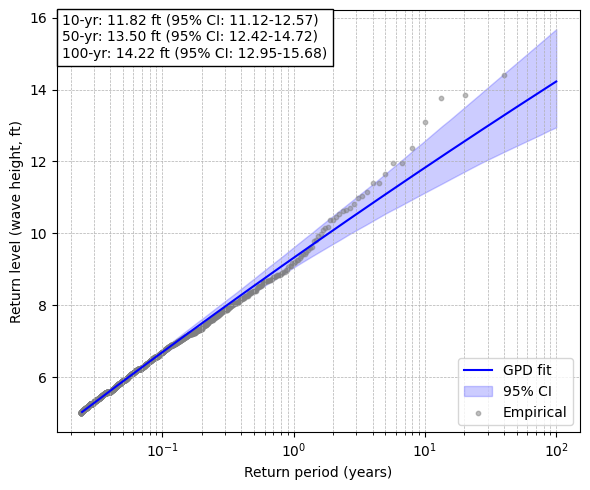

In [7]:
# Estimate return values (1 for 2004-2013, 2 for 1973-2013)
num = 2
fig_file = f'return_{num}.png'

if num == 1:
    SWH = daily_max_obs
elif num == 2:
    SWH = pd.concat([daily_max_pred, daily_max_obs], axis=0)

# Fit GPD to exceedances
exceed = SWH[SWH > thresh] - thresh
xi, _, sigma = stats.genpareto.fit(exceed, floc=0)
print(f'GPD parameters: xi = {xi:.4f}, sigma = {sigma:.4f}')

# Return periods in days
exceed_rate = len(exceed) / len(SWH)
return_periods = np.logspace(np.log10(0.01), np.log10(100), 300) * 365
return_levels = thresh + (sigma / xi) * ((return_periods * exceed_rate) ** xi - 1)
print(f'Exceedance rate = {exceed_rate:.4f} ({len(exceed)} exceedances over {len(SWH)} records)')

# Bootstrap confidence intervals
n_bootstrap = 1000
bootstrap_levels = np.zeros((n_bootstrap, len(return_periods)))

for i in range(n_bootstrap):
    resampled = np.random.choice(exceed, size=len(exceed), replace=True)
    xi_b, _, sigma_b = stats.genpareto.fit(resampled, floc=0)
    try:
        rl_b = thresh + (sigma_b / xi_b) * ((return_periods * exceed_rate) ** xi_b - 1)
        bootstrap_levels[i, :] = rl_b
    except:
        bootstrap_levels[i, :] = np.nan

lower_bound = np.percentile(bootstrap_levels, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_levels, 97.5, axis=0)

# Return level plot
plt.figure(figsize=(6, 5))
mask1 = return_levels > thresh
plt.plot(return_periods[mask1] / 365, return_levels[mask1], color='b', label='GPD fit')
plt.fill_between(return_periods[mask1] / 365, lower_bound[mask1], upper_bound[mask1], color='b', alpha=0.2, label='95% CI')

# Add empirical points
sorted_SWH = np.sort(SWH.dropna())[::-1]
emp_return_periods = (len(sorted_SWH) + 1) / np.arange(1, len(sorted_SWH) + 1)
mask2 = sorted_SWH > thresh
plt.scatter(emp_return_periods[mask2] / 365, sorted_SWH[mask2], color='gray', s=10, alpha=0.5, label='Empirical')

plt.xscale('log')
plt.xlabel('Return period (years)')
plt.ylabel('Return level (wave height, ft)')
plt.grid(True, which="both", ls="--", lw=0.5)

# Highlight selected return periods
yr_oi = [10, 50, 100]
idx_oi = [np.argmin(np.abs(return_periods - 365 * d)) for d in np.array(yr_oi)]
rl_oi = return_levels[idx_oi]
lb_oi = lower_bound[idx_oi]
ub_oi = upper_bound[idx_oi]

legend_text = "\n".join([f"{yr}-yr: {rl:.2f} ft (95% CI: {lb:.2f}-{ub:.2f})" for yr, rl, lb, ub in zip(yr_oi, rl_oi, lb_oi, ub_oi)])
plt.gca().text(0.01, 0.99, legend_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gca().transAxes, ha='left', va='top')
plt.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(fig_file, dpi=1200, format='png')
plt.show()